In [27]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf
from scipy.fft import fft2, fftshift

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True


In [21]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 250
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)

(250, 2)
(2,)
(180, 128, 184)
(1, 360)
(180, 128, 184)


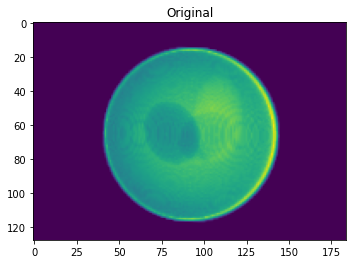

In [13]:
# Checking shape of original data
print(data.shape)
print(data[0].shape)
print(data[0][0][0, 0].shape)
print(data[0][1].shape)

# Getting rid of dimensions added for neural networks in order to plot
test_proj = np.squeeze(data[0][0])
print(test_proj.shape)

# Plot example projection
plt.imshow(test_proj[45, :, :])
plt.title('Original')
plt.show()

In [14]:
def fourier_reprojection(data, entries):
    
    ang = tomopy.angles(data[0][0][0, 0].shape[0])
    _rec = 1e-12 * np.ones((data[0][0][0, 0].shape[1], data[0][0][0, 0].shape[2], data[0][0][0, 0].shape[2]))
    data_copy = data.copy()
    out_data = data.copy()
    
    for i in range (entries):
    
        rec = tomopy.recon(data_copy[i][0][0, 0], ang, center = None, 
                            algorithm = 'gridrec', init_recon = _rec)
        reproj = tomopy.project(rec, ang, center = None, pad = False)
        
        out_data[i][0][0, 0] = fftshift(fft2(data_copy[i][0] - reproj))
        
    return out_data

In [15]:
fourier_reproj = fourier_reprojection(data.copy(), entries)

print(fourier_reproj.shape)
print(fourier_reproj[0].shape)
print(fourier_reproj[0][0].shape)
print(fourier_reproj[0][1].shape)

/tmp/ipykernel_7452/3321034711.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  out_data[i][0][0, 0] = fftshift(fft2(data_copy[i][0] - reproj))


(250, 2)
(2,)
(1, 1, 180, 128, 184)
(1, 360)


In [23]:
ang = tomopy.angles(data[0][0][0, 0].shape[0])
data_copy = data.copy()
_rec = 1e-12 * np.ones((data[0][0][0, 0].shape[1], data[0][0][0, 0].shape[2], data[0][0][0, 0].shape[2]))
rec = tomopy.recon(data_copy[1][0][0, 0], ang, center = None, 
                            algorithm = 'gridrec', init_recon = _rec)
reproj = tomopy.project(rec, ang, center = None, pad = False)

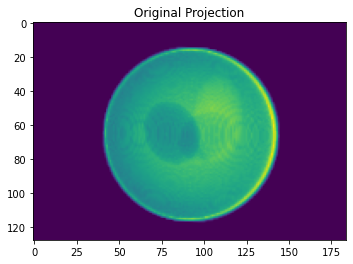

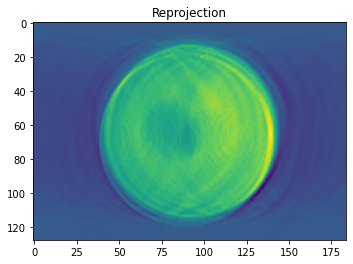

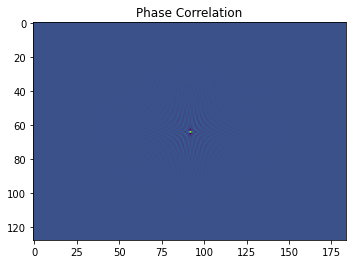

In [28]:
# Plot original projection
plt.imshow(data[0, 0][0, 0, 45, :, :])
plt.title('Original Projection')
plt.show()

# Plot reprojection
plt.imshow(reproj[45, :, :])
plt.title('Reprojection')
plt.show()

# Plot fourier difference
plt.imshow(fourier_reproj[0, 0][0, 0, 45, :, :])
plt.title('Phase Correlation')
plt.show()